# Modeling and Analysis
*Deval Mehta*

With EDA complete, we move on to our main task: creating data-driven models to make better decisions about bus routes. In addition to the conventional machine learning models we have discussed throughout the course of DSB, we explore **graph-based analysis** here, treating the network of bus stops across eastern Queens as a graph, where the nodes are stops and the edges are connections between stops, based either on established routes or using a distance heuristic. Our goals for modeling are as follows:
- Instantiate and run DBSCAN to check for areas of high and low density, which will be transit hubs and underserved areas
- Model the stop network as a graph, then use PageRank to define transit hubs and underserved areas

## Imports and Reading in Data

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import glob
import networkx as nx
from tqdm import tqdm

from geopy.distance import geodesic
from itertools import combinations
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [20]:
# Neighborhood boundaries
nyc_map = gpd.read_file('../data/nyc_by_neighborhood_2020.geojson')
queens_map = nyc_map[nyc_map['boroname'] == 'Queens']

In [2]:
# File Paths
data_directory = "../data/"  # Relative path to the data directory
static_data_file = f"{data_directory}stops.csv"
real_time_files_pattern = f"{data_directory}realtime_data_MTA NYCT_*.csv"

# Load Static Data
stops_data = pd.read_csv(static_data_file)

# Rename columns for consistency with the data dictionary
stops_data.rename(
    columns={
        "Route ID": "route_id",
        "Stop ID": "stop_id",
        "Stop Name": "stop_name",
        "Latitude": "stop_lat",
        "Longitude": "stop_lon",
    },
    inplace=True,
)

In [3]:
# Load Real-Time Data
real_time_files = glob.glob(real_time_files_pattern)
real_time_data = pd.concat([pd.read_csv(file) for file in real_time_files], ignore_index=True)

# Rename columns for consistency with the data dictionary
real_time_data.rename(
    columns={
        "Route ID": "route_id",
        "Vehicle ID": "vehicle_id",
        "Latitude": "vehicle_lat",
        "Longitude": "vehicle_lon",
        "Timestamp": "timestamp",
    },
    inplace=True,
)

# Ensure `timestamp` is parsed as a datetime object
real_time_data["timestamp"] = pd.to_datetime(real_time_data["timestamp"])

# Add coordinates column for convenience in static data
stops_data["coords"] = stops_data[["stop_lat", "stop_lon"]].apply(tuple, axis=1)

In [35]:
# Function to visualize results
def visualize_clusters(df, cluster_col, title, map_data=None, map_color="white", map_edgecolor="navy"):
    """
    Visualizes clusters overlaid on a map.

    Parameters:
    - df: GeoDataFrame or DataFrame containing stop coordinates (must include 'geometry').
    - cluster_col: Column name for cluster assignments or PageRank scores.
    - title: Title for the plot.
    - map_data: GeoDataFrame for the map (e.g., Queens boundaries). Default is None.
    - map_color: Color for the map base layer.
    - map_edgecolor: Edge color for the map base layer.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the map base layer if provided
    if map_data is not None:
        map_data.plot(ax=ax, color=map_color, edgecolor=map_edgecolor)
    
    # Plot the clusters or data points
    df.plot(
        ax=ax,
        column=cluster_col,
        cmap="tab20b" if cluster_col == "cluster" else "Blues",
        markersize=10 if cluster_col == "cluster" else df["pagerank"] * 10000,
        alpha=0.7,
        legend=True
    )
    
    # Add title and labels
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

## DBSCAN

In [22]:
# Step 1: Run DBSCAN
eps = 0.0005  # Adjust based on your data
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="haversine")
stops_data["cluster"] = dbscan.fit_predict(np.radians(stops_data[["stop_lat", "stop_lon"]]))

In [23]:
# Step 2: Save and Visualize Clusters
stops_data.to_csv(f"{data_directory}dbscan_clusters.csv", index=False)
print("DBSCAN Cluster Counts:")
print(stops_data["cluster"].value_counts())

DBSCAN Cluster Counts:
cluster
0    2281
1      19
Name: count, dtype: int64


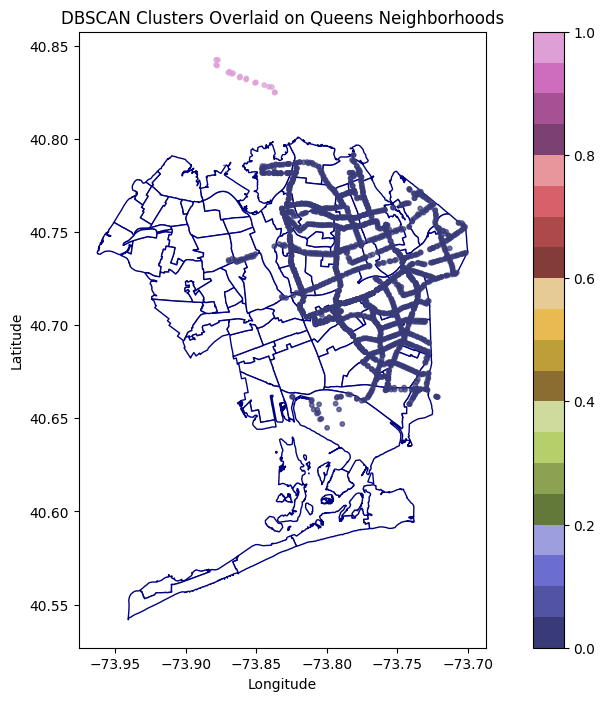

In [36]:
# Convert stops_data to GeoDataFrame if not already done
stops_gdf = gpd.GeoDataFrame(
    stops_data,
    geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]),
    crs="EPSG:4326"
)

# Visualize DBSCAN Clusters with the Queens map
visualize_clusters(
    stops_gdf, 
    cluster_col="cluster", 
    title="DBSCAN Clusters Overlaid on Queens Neighborhoods", 
    map_data=queens_map
)

In [ ]:
# TODO: HDBSCAN

## PageRank
PageRank was developed by Google to rank webpages by importance, using the number of links leading to them as a proxy. It has since been generalized to apply to any directed graph. Modeling bus stops in this way should allow us to identify areas of high and low density, just as clustering would, but without machine learning.

In [12]:
# Step 1: Construct Edges Based on Proximity
distance_threshold = 0.1  # in kilometers (500 meters)
edges = []

print("Constructing edges for PageRank...")
for stop1, stop2 in tqdm(combinations(stops_data["stop_id"], 2), desc="Computing edges"):
    coord1 = stops_data.loc[stops_data["stop_id"] == stop1, "coords"].values[0]
    coord2 = stops_data.loc[stops_data["stop_id"] == stop2, "coords"].values[0]
    if geodesic(coord1, coord2).kilometers <= distance_threshold:
        edges.append((stop1, stop2))

Constructing edges for PageRank...


Computing edges: 2643850it [28:10, 1563.54it/s]


In [13]:
# Step 2: Create a Directed Graph
G = nx.DiGraph()

# Add nodes
for _, row in stops_data.iterrows():
    G.add_node(row["stop_id"], latitude=row["stop_lat"], longitude=row["stop_lon"])

# Add edges
G.add_edges_from(edges)

In [14]:
# Step 3: Compute PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85)
stops_data["pagerank"] = stops_data["stop_id"].map(pagerank_scores)

# Step 4: Save and Visualize PageRank Results
stops_data.to_csv(f"{data_directory}pagerank_results.csv", index=False)
print("Top 10 Bus Stops by PageRank:")
print(stops_data.sort_values("pagerank", ascending=False).head(10))

Top 10 Bus Stops by PageRank:
             route_id     stop_id                 stop_name   stop_lat  \
574    MTA%20NYCT_Q13  MTA_505121       39 AV/LIPPMAN PLAZA  40.760694   
1046   MTA%20NYCT_Q28  MTA_505121       39 AV/LIPPMAN PLAZA  40.760694   
802   MTA%20NYCT_Q20B  MTA_505021  15 AV/COLLEGE POINT BLVD  40.784153   
678   MTA%20NYCT_Q20A  MTA_505021  15 AV/COLLEGE POINT BLVD  40.784153   
67      MTA%20NYCT_Q1  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
135     MTA%20NYCT_Q2  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1351   MTA%20NYCT_Q36  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1717   MTA%20NYCT_Q76  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1833   MTA%20NYCT_Q77  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1447   MTA%20NYCT_Q43  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   

       stop_lon                   coords  cluster  pagerank  
574  -73.828177  (40.760694, -73.828177)        0  0.004104  
1046 -73.828177  (40.760694, -7

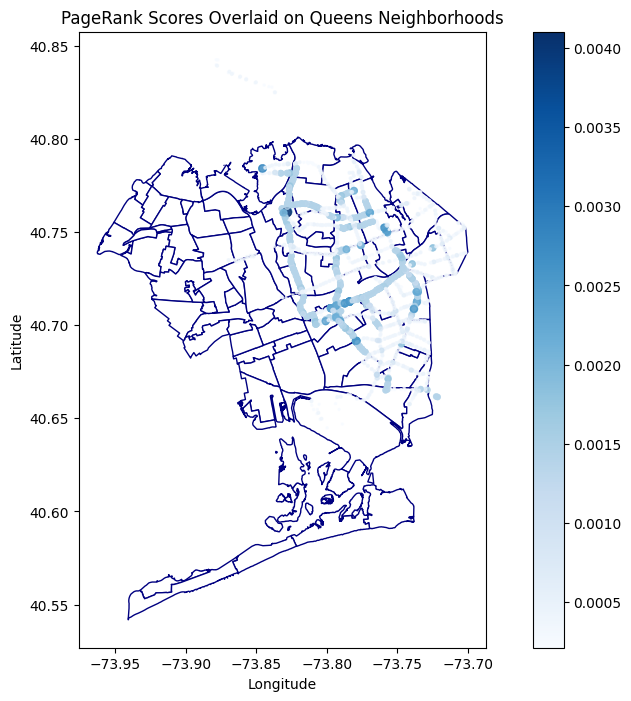

In [37]:
# Visualize PageRank Scores with the Queens map
visualize_clusters(
    stops_gdf, 
    cluster_col="pagerank", 
    title="PageRank Scores Overlaid on Queens Neighborhoods", 
    map_data=queens_map
)